In [32]:
# common:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
# import folium

# for ML:
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
# from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

#### Import dataset and familiar with it

In [2]:
booking = pd.read_csv('hotel_bookings.csv')
print("Observations in the dataset:",len(booking))
booking.head()

Observations in the dataset: 119390


,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


#### Cleaning and preprocessing data
Check type of each column

In [3]:
booking.dtypes

hotel                              object
is_canceled                         int64
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
agent                             

check for missing values

In [12]:
booking.isnull().sum()

hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          4
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
agent                             0
company                           0
days_in_waiting_list              0
customer_type                     0
adr                         

Replace values and drop rows with zero guests

In [14]:
booking = booking.fillna({"children:": 0.0,"country": "Unknown", "agent": 0.0, "company": 0.0})

# the "meal" column contains "Undefined", which is equal to SC
booking["meal"].replace("Undefined", "SC", inplace=True)

# Some rows contain entreis with 0 adults, 0 children and 0 babies, so we need to drop these rows.
zero_guests = list(booking.loc[booking["adults"]+ booking["children"] + booking["babies"]==0].index)
booking = booking.drop(booking.index[zero_guests])

print("Observations in the dataset after preprocessing:",len(booking))

Observations in the dataset after preprocessing: 119210


#### Data analysis
To analyse where the guests come from

In [41]:
# get bookings that are not canceled
not_canceled_booking = booking.loc[booking["is_canceled"] == 0]
print("number of non-canceled bookings:", len(not_canceled_booking))

number of successful bookings: 75011


In [33]:
country_count = pd.DataFrame(not_canceled_booking['country'].value_counts())
country_count.rename(columns={"country": "Number of Guests"}, inplace=True)

total_guests = country_count["Number of Guests"].sum()
country_count['Guests in %'] = round(country_count["Number of Guests"] / total_guests * 100, 2)
country_count["country"] = country_count.index

# set some display options:
sns.set(style="whitegrid")

# pie plot
fig = px.pie(country_count,
             values="Number of Guests",
             names="country",
             title="Home country of guests",
             template="seaborn")
fig.update_traces(textposition="inside", textinfo="value+percent+label")
fig.show()

To analyse how much do guests pay for a room per night

In [42]:
# separate Resort and City hotel
# Resort Hotel
rh = not_canceled_booking[not_canceled_booking["hotel"] == "Resort Hotel"]
# City Hotel
ch = not_canceled_booking[not_canceled_booking["hotel"] == "City Hotel"]

print("Number of non-canceled bookings for Resort Hotel:", len(rh))
print("Number of non-canceled bookings for City Hotel:", len(ch))

Number of bookings for Resort Hotel: 28927
Number of bookings for City Hotel: 46084


In [45]:
rh_price = rh["adr"] / (rh["adults"] + rh["children"])
ch_price = ch["adr"] / (ch["adults"] + ch["children"])

print("The average price: \nResort Hotel: {:.2f} per night and person \nCity Hotel: {:.2f} per night and person"
      .format(rh_price.mean(), ch_price.mean()))

The average price: 
Resort Hotel: 47.49 per night and person 
City Hotel: 59.27 per night and person


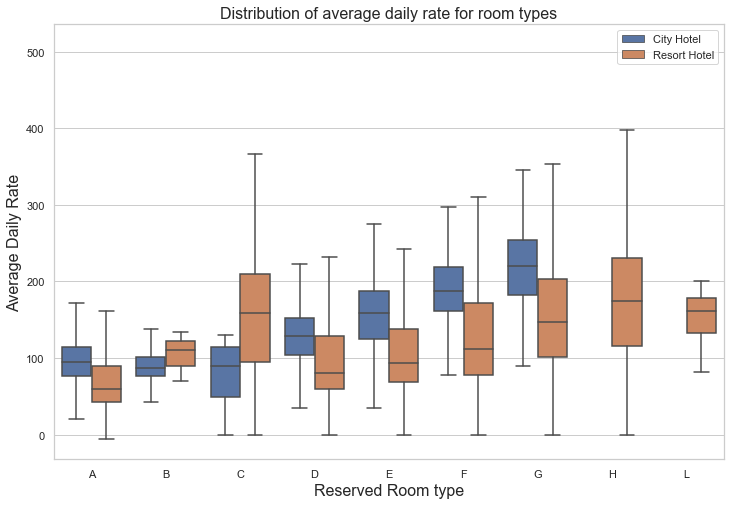

In [52]:
room_prices = not_canceled_booking[["hotel", "reserved_room_type", "adr"]].sort_values("reserved_room_type")

plt.figure(figsize=(12, 8))
sns.boxplot(x="reserved_room_type",
            y="adr",
            hue="hotel",
            data=room_prices, 
            hue_order=["City Hotel", "Resort Hotel"],
            fliersize=0)
plt.title("Distribution of average daily rate for room types", fontsize=16)
plt.xlabel("Reserved Room type", fontsize=16)
plt.ylabel("Average Daily Rate", fontsize=16)
plt.legend(loc="upper right")
plt.show()